# MLP for HZZ4l analysis using  Keras
Authors: Javier Duarte, Thong Nguyen     
Modified: Andre Sznajder

## **Mount Google Drive**

In [1]:
!fusermount -u drive
!pip install uproot

fusermount: failed to unmount /content/drive: No such file or directory
    100% |████████████████████████████████| 102kB 19.9MB/s 
    100% |████████████████████████████████| 81kB 20.6MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Bari_Lectures/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Load data using PANDAS data frames#
Now we load two different `NumPy` arrays. One corresponding to the VBF H->ZZ->4l signal and the other one corresponds to the QCD ZZ->4l background .

In [0]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['VV'] = base_dir+'Data/ntuple_qqH_ZZ4mu.root'
filename['bkg'] = base_dir+'Data/ntuple_bkg_ZZ4mu.root'


# Variables from Roottree to be copyed to PANDA dataframe
VARS = ['f_lept1_pt','f_lept1_eta','f_lept1_phi', \
        'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
        'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
        'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
        'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
        'f_jet2_pt','f_jet2_eta','f_jet2_phi',\
        'f_mass4l','f_massjj','f_deltajj']
        

upfile['VV'] = uproot.open(filename['VV'])
upfile['bkg'] = uproot.open(filename['bkg'])

params['VV'] = upfile['VV'][treename].arrays(VARS)
params['bkg'] = upfile['bkg'][treename].arrays(VARS)

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# Remove undefined variable entries VARS[i] <= -999
NDIM = len(VARS)
for i in range(NDIM):
    df['VV'] = df['VV'][(df['VV'][VARS[i]] > -999)]
    df['bkg']= df['bkg'][(df['bkg'][VARS[i]] > -999)]


# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

## **Specify the number of NN input variables **

In [0]:

# Define the NN input variables 
#NVARS = len(VARS)
NVARS = len(VARS) - 3



## Define the model using KERAS functional API 
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The output layer contains a single neuron using a sigmoid activation in order to a number between 0 and 1 to make binary classification

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [0]:
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Activation, Dense, Dropout
from keras.utils import np_utils

# Select the NN input variables. Using just lepton and and jets 4-mom ( low level variables) ! 
input  = Input(shape=(NVARS,), name = 'input') 
hidden = Dense(NVARS , name = 'hidden', kernel_initializer='normal', activation='relu')(input)
hidden = Dropout(rate=0.5)(hidden)
hidden1 = Dense(NVARS  , name = 'hidden1', kernel_initializer='normal', activation='relu')(input)
hidden1 = Dropout(rate=0.2)(hidden1)
hidden2 = Dense(NVARS  , name = 'hidden2', kernel_initializer='normal', activation='relu')(hidden1)
hidden2 = Dropout(rate=0.4)(hidden2)
hidden3 = Dense(NVARS  , name = 'hidden3', kernel_initializer='normal', activation='relu')(hidden2)
hidden3 = Dropout(rate=0.6)(hidden3)
output  = Dense(1      , name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)
output2  = Dense(1      , name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden3)


# create the model
model1 = Model(inputs=input, outputs=output)
model2 = Model(inputs=input, outputs=output2)
# Define the optimizer ( minimization algorithm )
# SGD Stochastic Gradient Descent
#optim1 = SGD(lr=0.01,decay=1e-6) 
optim2 = Adam()
# compile the model
model1.compile(optimizer=optim2, loss='binary_crossentropy', metrics=['accuracy'])
model2.compile(optimizer=optim2, loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
#model1.summary()
#model2.summary()

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 


In [0]:
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=6)
X_train_val2, X_test2, Y_train_val2, Y_test2 = train_test_split(X, Y, test_size=0.2, random_state=6)

## Run NN Training 


In [26]:
# Number of training epochs
nepochs=100
# Batch size
batch=100
# Train classifier
history1 = model1.fit(X_train_val[:,0:NVARS], 
                    Y_train_val, 
                    epochs=nepochs, 
                    batch_size=batch, 
                    verbose=1, # switch to 1 for more verbosity 
                    validation_split=0.3)

history2 = model2.fit(X_train_val2[:,0:NVARS], 
                    Y_train_val2, 
                    epochs=nepochs, 
                    batch_size=batch, 
                    verbose=1, # switch to 1 for more verbosity 
                    validation_split=0.3)

Train on 8072 samples, validate on 3460 samples
Epoch 1/100
8072/8072 [==============================] - 1s 72us/step - loss: 0.4786 - acc: 0.8295 - val_loss: 0.2541 - val_acc: 0.9145
Epoch 2/100
8072/8072 [==============================] - 0s 36us/step - loss: 0.2755 - acc: 0.9180 - val_loss: 0.2278 - val_acc: 0.9231
Epoch 3/100
8072/8072 [==============================] - 0s 39us/step - loss: 0.2544 - acc: 0.9207 - val_loss: 0.2129 - val_acc: 0.9292
Epoch 4/100
8072/8072 [==============================] - 0s 37us/step - loss: 0.2482 - acc: 0.9255 - val_loss: 0.2082 - val_acc: 0.9306
Epoch 5/100
8072/8072 [==============================] - 0s 39us/step - loss: 0.2392 - acc: 0.9275 - val_loss: 0.2078 - val_acc: 0.9292
Epoch 6/100
8072/8072 [==============================] - 0s 41us/step - loss: 0.2338 - acc: 0.9284 - val_loss: 0.2062 - val_acc: 0.9298
Epoch 7/100
8072/8072 [==============================] - 0s 36us/step - loss: 0.2376 - acc: 0.9281 - val_loss: 0.2053 - val_acc: 0.9315


## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

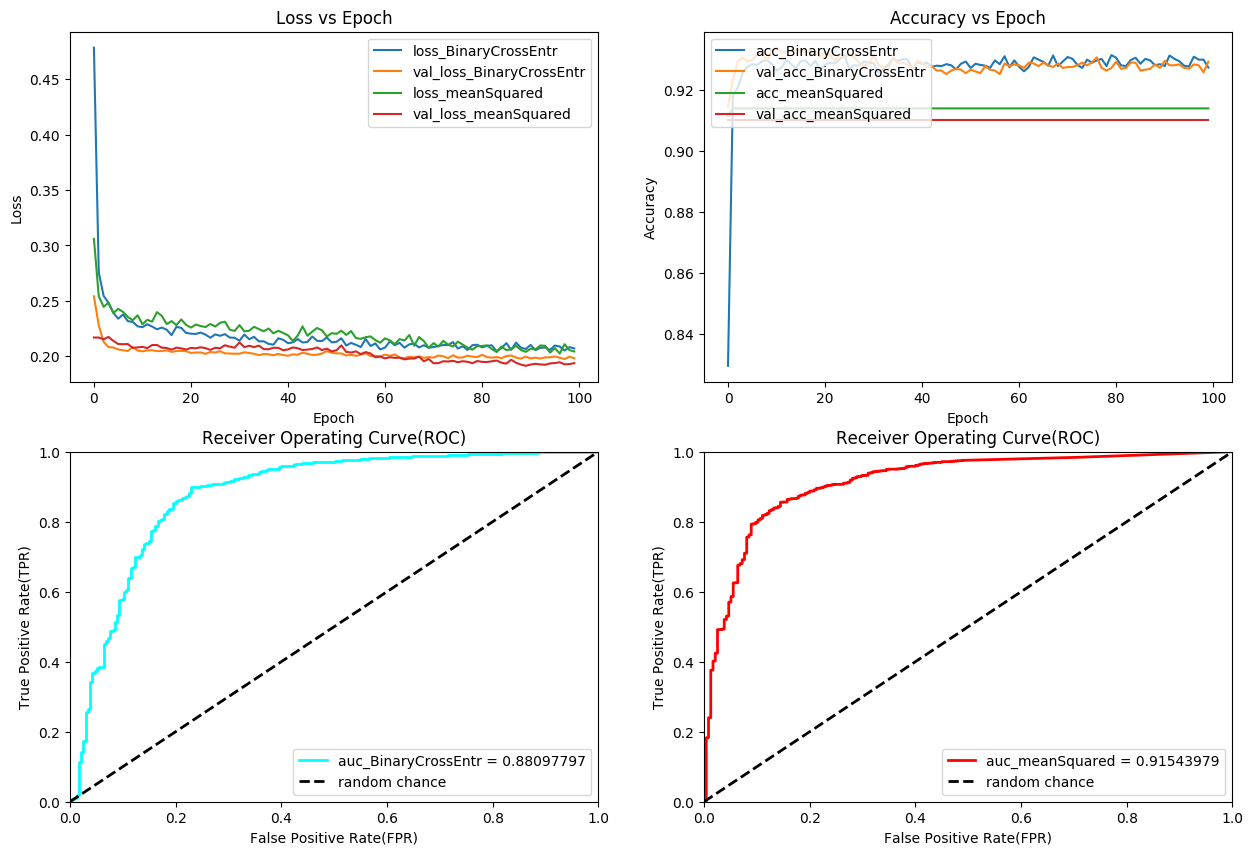

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
plt.figure(figsize=(15,10))

#### first model
# plot loss vs epoch
ax = plt.subplot(2, 2, 1)
ax.plot(history1.history['loss'], label='loss_BinaryCrossEntr')
ax.plot(history1.history['val_loss'], label='val_loss_BinaryCrossEntr')
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Epoch')


# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history1.history['acc'], label='acc_BinaryCrossEntr')
ax.plot(history1.history['val_acc'], label='val_acc_BinaryCrossEntr')
ax.legend(loc="upper left")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Epoch')


# Plot ROC
Y_predict1 = model1.predict(X_test[:,0:NVARS])
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict1)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc_BinaryCrossEntr = %.8f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate(FPR)')
ax.set_ylabel('True Positive Rate(TPR)')
ax.set_title('Receiver Operating Curve(ROC)')
ax.legend(loc="lower right")

#### Second model
# plot loss vs epoch
ax = plt.subplot(2, 2, 1)
ax.plot(history2.history['loss'], label='loss_meanSquared')
ax.plot(history2.history['val_loss'], label='val_loss_meanSquared')
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history2.history['acc'], label='acc_meanSquared')
ax.plot(history2.history['val_acc'], label='val_acc_meanSquared')
ax.legend(loc="upper left")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Plot ROC
Y_predict2 = model2.predict(X_test2[:,0:NVARS])
#from sklearn.metrics import roc_curve, auc
fpr2, tpr2, thresholds2 = roc_curve(Y_test2, Y_predict2)
roc_auc2 = auc(fpr2, tpr2)
ax = plt.subplot(2, 2, 4)
ax.plot(fpr2, tpr2, lw=2, color='red', label='auc_meanSquared = %.8f' % (roc_auc2))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate(FPR)')
ax.set_ylabel('True Positive Rate(TPR)')
ax.set_title('Receiver Operating Curve(ROC)')
ax.legend(loc="lower right")

plt.show()


# Plot  $m_{jj}$, $\eta_{j}$ and $m_{4l}$  for NN output > cut to show that the NN did learned the physics !


(50, 400)

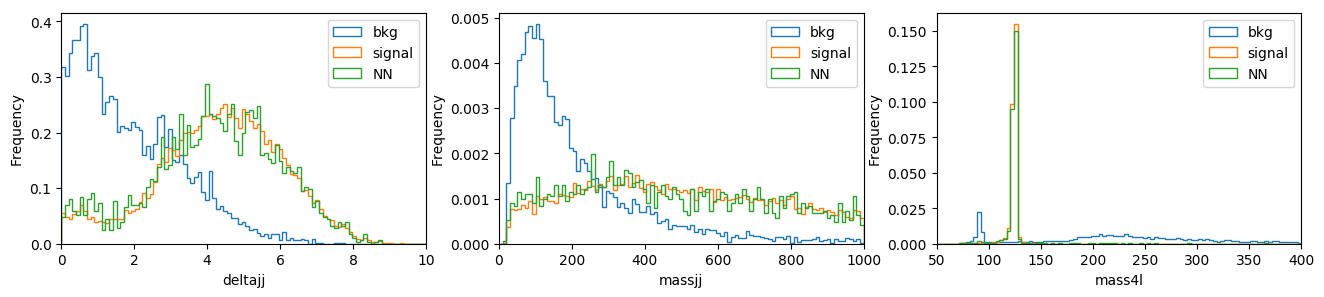

In [0]:

import matplotlib.pyplot as plt

# Define pandas dataframes the variables
VARS=['f_deltajj','f_massjj','f_mass4l']
params['VV'] = upfile['VV'][treename].arrays(VARS)
params['bkg'] = upfile['bkg'][treename].arrays(VARS)
df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# Remove events with undefined variable entries VARS[i] <= -999
N = len(VARS)
for i in range(N):
    df['VV'] = df['VV'][(df['VV'][VARS[i]] > -999)]
    df['bkg']= df['bkg'][(df['bkg'][VARS[i]] > -999)]


# Define the data frame for NN predictions and high level variables
data = pd.DataFrame({'f_mass4l':X_test[:,18],'f_massjj':X_test[:,19],'f_deltajj':X_test[:,20],'NNoutput':Y_predict[:,0]})

# Selects events with NNoutput > cut
cut = 0.5 
data = data[(data['NNoutput'] > cut)]

    
# Plot  delta_eta between jets for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 3),dpi=100)

plt.subplot(1, 3, 1)
plt.xlabel('deltajj')
bins = np.linspace(0, 10, 100)
df['bkg']['f_deltajj'].plot.hist(bins, label='bkg',histtype='step', density=1)
df['VV']['f_deltajj'].plot.hist(bins, label='signal',histtype='step', density=1)
data['f_deltajj'].plot.hist(bins, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,10)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(1, 3, 2)
plt.xlabel('massjj')
bins = np.linspace(0, 1000, 100)
df['bkg']['f_massjj'].plot.hist(bins, label='bkg',histtype='step', density=1)
df['VV']['f_massjj'].plot.hist(bins, label='signal',histtype='step', density=1)
data['f_massjj'].plot.hist(bins, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,1000)

# Plot 4l invariant mass for signal, background and NN selected events 
plt.subplot(1, 3, 3)
plt.xlabel('mass4l')
bins = np.linspace(50, 400, 100)
df['bkg']['f_mass4l'].plot.hist(bins, label='bkg',histtype='step', density=1)
df['VV']['f_mass4l'].plot.hist(bins, label='signal',histtype='step', density=1)
data['f_mass4l'].plot.hist(bins, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(50,400)




**Question 1:** What happens if you increase/decrease the number of hidden layers ?



**Question 2:** What happens if you increase/decrease the number of nodes per hidden layer ?



**Question 3:** What happens if you remove dropout ?



**Question 4:** What happens if you change the batch size  ?



